# Setup

In [ ]:
%pip install wbdata

import wbdata
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

In [ ]:
#wbdata.get_countries()

# We will be using ESP, MEX, IND

In [ ]:
#wbdata.get_sources()

# We will be using source 40, "Population estimates and projections"

Reference the variables returned by *indicators* for data exploration.



In [ ]:
SOURCE = 40 # "Population estimates and projections"

indicators = wbdata.get_indicators(source=SOURCE)
indicators

id                 name
-----------------  -------------------------------------------------------------------
SH.DTH.0509        Number of deaths ages 5-9 years
SH.DTH.0514        Number of deaths ages 5-14 years
SH.DTH.1014        Number of deaths ages 10-14 years
SH.DTH.1019        Number of deaths ages 10-19 years
SH.DTH.1519        Number of deaths ages 15-19 years
SH.DTH.2024        Number of deaths ages 20-24 years
SH.DTH.IMRT        Number of infant deaths
SH.DTH.IMRT.FE     Number of infant deaths, female
SH.DTH.IMRT.MA     Number of infant deaths, male
SH.DTH.MORT        Number of under-five deaths
SH.DTH.MORT.FE     Number of under-five deaths, female
SH.DTH.MORT.MA     Number of under-five deaths, male
SH.DTH.NMRT        Number of neonatal deaths
SH.DYN.0509        Probability of dying among children ages 5-9 years (per 1,000)
SH.DYN.0514        Probability of dying at age 5-14 years (per 1,000 children age 5)
SH.DYN.1014        Probability of dying among adolescents ages 1

# [A] Population Statistics

Write a population function that will return the population count for the input country in the given year.

In [ ]:
countries = wbdata.get_countries()
country_dict = {}
for country in countries:
    country_code = country['id']
    country_name = country['name']
    country_dict[country_name] = country_code

def int_to_str(num):
  if 0 <= num < 10:
        return f"0{num}"
  else:
        return str(num)

def population_range(year, sex, age_range, place):
  sex_codes = {"people": "", "females": "FE", "males": "MA"}
  if sex not in sex_codes:
        raise ValueError("Sex must be one of: 'people', 'females', or 'males'.")
  sex_used = sex_codes[sex]

  if age_range[0] >= 80:
    indicator_code = "SP.POP.80UP." + sex_used

  elif age_range[0] == 0:
    indicator_code = "SP.POP.0004." + sex_used
  else:
    lower, upper = int_to_str(age_range[0]), int_to_str(age_range[1])
    range_string = lower + upper

    indicator_code = "SP.POP." + range_string + "." + sex_used

  country_code = country_dict.get(place)
  if country_code is None:
        raise ValueError(f"Place '{place}' not found. Please check.")
  df = wbdata.get_dataframe({indicator_code: "Population"},
                              country={country_code: place})

  if df.empty:
        raise ValueError(f"No data found for {place} in {year} using indicator '{indicator_code}'.")

  df = df.squeeze().to_frame().reset_index()

  matching = df[df["date"] == str(year)]
  if matching.empty:
        raise ValueError(f"No data available for the year {year}.")

  population_total = int(matching["Population"].iloc[0])
  return population_total

def dict_helper1(year, sex, age_range, place):


  if len(age_range) == 1:
        age_range = [age_range[0], age_range[0]]
  elif age_range[1] < age_range[0]:
        raise ValueError("Please ensure that the second value in the range is greater than the first.")

  minimum_age, maximum_age = age_range

  possible_minimums = list(range(0, 76, 5))
  possible_maximums = list(range(4, 120, 5))

  age_population = {}

  for age in range(minimum_age, maximum_age + 1):
      range_index = next((i for i, min_val in enumerate(possible_minimums)
                            if min_val <= age <= possible_maximums[i]), None)
  if range_index is not None:
          group_population = population_range(year, sex,
                                                  [possible_minimums[range_index], possible_maximums[range_index]],
                                                  place)
          per_age_population = group_population // 5
          age_population[age] = per_age_population
  else:
          group_population = population_range(year, sex,
                                                  [possible_minimums[-1], possible_maximums[-1]],
                                                  place)
          per_age_population = group_population // 5
          age_population[age] = per_age_population
  return age_population

def dict_helper(year, sex, age_range, place):
  total = 0
  for x in range(age_range[0], age_range[1]):
     if age_range[1] or age_range[0] >= 80:
      total += population_range(year, sex, [80, None], place)
     else:
      total += sum(dict_helper1(year, sex, [x, x], place).values())
  return total

def population(year, sex, age_range, place):
  if place not in country_dict:
        valid_regions = ", ".join(country_dict.keys())
        raise ValueError(f"The region '{place}' is not valid. Valid regions include: {valid_regions}")
  if sex.lower() in ["all", "people", "p", "everyone"]:
    female_data = dict_helper(year, "females", age_range, place)
    male_data = dict_helper(year, "males", age_range, place)
    total_population = male_data + female_data
  elif sex.lower() in ["female", "females", "f", "fe"]:
        female_data = dict_helper(year, "females", age_range, place)
        total_population = female_data
  elif sex.lower() in ["male", "males", "m", "ma"]:
        male_data = dict_helper(year, "males", age_range, place)
        total_population = male_data
  else:
        raise ValueError("Sex not recognized. Please use a valid input such as 'people', 'females', or 'males'.")

  #print(f"In {year} how many {sex} aged {age_range[0]} to {age_range[1]} were living in {place}? {total_population} people!!")
  return total_population

#example:
population(2010, 'male', [1, 95], 'United States')

381066130

In [ ]:
%debug

> /usr/local/lib/python3.11/dist-packages/wbdata/fetcher.py(46)from_response()
     44             try:
     45                 message = response[0]["message"][0]
---> 46                 raise RuntimeError(
     47                     f"Got error {message['id']} ({message['key']}): "
     48                     f"{message['value']}"

ipdb> up
> /usr/local/lib/python3.11/dist-packages/wbdata/fetcher.py(129)_get_response()
    127             body = self._get_response_body(url, params)
    128             self.cache[key] = body
--> 129         return ParsedResponse.from_response(tuple(json.loads(body)))
    130 
    131     def fetch(

ipdb> up
> /usr/local/lib/python3.11/dist-packages/wbdata/fetcher.py(155)fetch()
    153         rows: List[Dict[str, Any]] = []
    154         while pages != page:
--> 155             response = self._get_response(
    156                 url=url,
    157                 params=params,

ipdb> up
> /usr/local/lib/python3.11/dist-packages/wbdata/client.py


PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/lib/python3.11/bdb.py", line 361, in set_quit
    sys.settrace(None)



# [A] Population DataFrames

**Below is a function that returns a pandas DataFrame indexed by country and year, with columns giving counts of people in different age-sex groups.**

In [ ]:
def population_dataframe(years, countries, age_groups):
    # Create an empty list to store data
    data = []

    # Loop through countries, years, and age groups
    for country in countries:
        for year in years:
            row = {"Country": country, "Year": year}  # Initialize row for each country-year

            for age_range in age_groups:
                for sex in ["males", "females"]:  # Separate calculations for males and females
                    try:
                        total_population = population(year, sex, age_range, country)
                        row[f"{sex.capitalize()} {age_range[0]}-{age_range[1]}"] = total_population
                    except ValueError:
                        row[f"{sex.capitalize()} {age_range[0]}-{age_range[1]}"] = None  # Handle missing data

            data.append(row)

    # Convert list to DataFrame
    df = pd.DataFrame(data)

    # Set hierarchical index: Country → Year
    df.set_index(["Country", "Year"], inplace=True)

    return df

In [ ]:
# Example usage:
years = [1990, 1991, 1992, 1993]
countries = ["India", 'Mexico']  # Target countries
age_groups = [(0, 4), (5, 9), (10, 14), (15, 19), (20, 24), (25, 29), (30, 34), (35, 39),
              (40, 44), (45, 49), (50, 54), (55, 59), (60, 64), (65, 69), (70, 74), (75, 79)]

population_df = population_dataframe(years, countries, age_groups)
population_df

Males 0-4  Females 0-4  Males 5-9  Females 5-9  Males 10-14  \
Country Year                                                                
India   1990   51569772     47901884   46279004     42572716     40820856   
        1991   51982488     48264196   47205516     43437108     41793624   
        1992   52350284     48560760   48084088     44258652     42788456   
        1993   52706240     48820988   48860344     44983248     43839572   
Mexico  1990    4566568      4433836    4329392      4224824      4180608   
        1991    4606704      4471020    4337164      4241260      4164160   
        1992    4641712      4502872    4359412      4264920      4148692   
        1993    4668788      4529184    4397060      4296932      4145952   

              Females 10-14  Males 15-19  Females 15-19  Males 20-24  \
Country Year                                                           
India   1990       37683940     36386180       33822388     32241648   
        1991       38513076     37221576       34545864     32916260   
        1992       39373860     38046348       35249108     33634440   
        1993       40299352     38832212       35912628     34389624   
Mexico  1990        4129824      3808168        3932800      3093012   
        1991        4120176      3862620        3984512      3193972   
        1992        4124744      3886676        4006496      3296120   
        1993        4141892      3886796        4007612      3382768   

              Females 20-24  ...  Males 55-59  Females 55-59  Males 60-64  \
Country Year                 ...                                            
India   1990       29929884  ...     10008652        9864284      8004500   
        1991       30565400  ...     10193312       10113024      8173784   
        1992       31229364  ...     10395516       10368376      8337176   
        1993       31917848  ...     10603024       10616220      8498492   
Mexico  1990        3336608  ...       766396         821596       612552   
        1991        3433712  ...       792184         849596       631976   
        1992        3528028  ...       819028         879976       651840   
        1993        3610208  ...       846620         911332       673056   

              Females 60-64  Males 65-69  Females 65-69  Males 70-74  \
Country Year                                                           
India   1990        7800000      5816200        5848104      3843280   
        1991        8031288      5962668        6010736      3937644   
        1992        8272856      6118660        6182832      4034988   
        1993        8521004      6280764        6365012      4137688   
Mexico  1990         664620       460576         501820       322116   
        1991         686320       479720         523848       336632   
        1992         709548       498368         545508       352252   
        1993         734252       517156         567440       368092   

              Females 70-74  Males 75-79  Females 75-79  
Country Year                                             
India   1990        4137312      2184608        2576664  
        1991        4247728      2232980        2651080  
        1992        4359608      2291536        2732268  
        1993        4474520      2359048        2818408  
Mexico  1990         355488       219736         251328  
        1991         372340       225676         258788  
        1992         390248       232476         267784  
        1993         408212       240648         277984  

[8 rows x 32 columns]

**NOTE: Once the DataFrame function is defined, return 3 dataframes for Spain, Mexico, and India in their respective 3 years. Add a text cell(s) to describe the findings.**

**Below are functions that return birth and death rates for a given country and a list of years.**

In [ ]:
def get_birth_rate_data(country, years):
    """
    Retrieves birth rate data from the World Bank for the specified country and years.

    Parameters:
    - country (str): a country code (e.g., "IND")
    - years (list of int): List of years to filter (e.g., [2014, 2015, 2016]).

    Returns:
    - pd.DataFrame: A DataFrame with birth rate data for the given country and years.
    """
    birth_label = {"SP.DYN.CBRT.IN": "Birth Rate"}

    # Fetch data from the World Bank
    df = wbdata.get_dataframe(birth_label, country=country, parse_dates=True)

    # Filter for specified years
    df = df[df.index.year.isin(years)]

    # Add a name to the dataframe
    df.index.rename(f"{country}", inplace=True)

    return df

In [ ]:
def get_death_rate_data(country, years):
    """
    Retrieves death rate data from the World Bank for the specified country and years.

    Parameters:
    - country (str): a country code (e.g., "IND")
    - years (list of int): List of years to filter (e.g., [2014, 2015, 2016]).

    Returns:
    - pd.DataFrame: A DataFrame with death rate data for the given country and years.
    """
    death_label = {"SP.DYN.CDRT.IN":"Death Rate"}

    # Fetch data from the World Bank
    df = wbdata.get_dataframe(death_label, country=country, parse_dates=True)

    # Filter for specified years
    df = df[df.index.year.isin(years)]

    # Add a name to the dataframe
    df.index.rename(f"{country}", inplace=True)

    return df

**Using these functions, we compare birth and death rates between countries.**

In [ ]:
# Compare the birth rate of the three countries before, during, and after their extreme-heat event year.

esp1, ind1, mex1 = get_birth_rate_data("ESP", [2002, 2003, 2004]), \
                get_birth_rate_data("IND", [2014, 2015, 2016]), \
                get_birth_rate_data("MEX", [1997, 1998, 1999])

esp1, ind1, mex1

(            Birth Rate
 ESP                   
 2004-01-01        10.6
 2003-01-01        10.4
 2002-01-01        10.1,
             Birth Rate
 IND                   
 2016-01-01      18.514
 2015-01-01      18.765
 2014-01-01      19.049,
             Birth Rate
 MEX                   
 1999-01-01      24.618
 1998-01-01      24.925
 1997-01-01      25.511)

We expected to see that birth rates in the year following the extreme-heat event would drop. This is only true for India and Mexico.

In [ ]:
# Compare the death rate of the three countries before, during, and after their extreme-heat event year.

esp2, ind2, mex2 = get_death_rate_data("ESP", [2002, 2003, 2004]), \
                  get_death_rate_data("IND", [2014, 2015, 2016]), \
                  get_death_rate_data("MEX", [1997, 1998, 1999])

esp2, ind2, mex2

(            Death Rate
 ESP                   
 2004-01-01         8.6
 2003-01-01         9.1
 2002-01-01         8.8,
             Death Rate
 IND                   
 2016-01-01       6.603
 2015-01-01       6.670
 2014-01-01       6.790,
             Death Rate
 MEX                   
 1999-01-01       5.036
 1998-01-01       5.086
 1997-01-01       5.152)

We expected to see that the highest death rate in the 3-year periods would be in the second year, the year of the extreme heat event. Turns out, this is only true for Spain.

# [B] Population Pyramids

A python function that takes as input a pandas DataFrame with columns providing counts of people by age-sex groups, and constructs a “population pyramid” graph for visualizing the data.

In [ ]:
def plot_population_pyramid(country, year, age_groups):
    """
    Plots a population pyramid based on given country, year, and age groups (no need to create a dataframe first).

    Parameters:
    - country (str): Country name (e.g., 'Spain').
    - year (int): Year for the population data.
    - age_groups (list of tuples): List of age ranges (e.g., [(0, 4), (5, 9), (10, 14)]).
    """
    # This generates the population dataframe for the given parameters
    pop_df = population_dataframe([year], [country], age_groups)

    # This plots the population pyramid using the generated dataframe
    help_plot_population_pyramid(pop_df, country, year)

def help_plot_population_pyramid(df, country, year):
    """
    Plots a population pyramid based on a DataFrame containing population counts
    for various age-sex groups.

    Parameters:
    - df (pd.DataFrame): DataFrame with age-sex population counts.
    - country (str): Country name (e.g., 'Spain').
    - year (int): Year for the population data.
    """
    # Filter the DataFrame for the specified country and year
    df_filtered = df.loc[(country, year)]

    # Prepare the male and female data by separating the age-sex groups
    male_columns = [col for col in df_filtered.index if "Male" in col]
    female_columns = [col for col in df_filtered.index if "Female" in col]

    # Get population values for males and females
    male_data = df_filtered[male_columns].values
    female_data = df_filtered[female_columns].values

    # Replace None or NaN values with 0 to avoid TypeError
    male_data = np.nan_to_num(male_data)  # Convert None or NaN to 0
    female_data = np.nan_to_num(female_data)  # Convert None or NaN to 0

    # Create age group labels (assuming the data is ordered in the same way)
    age_groups = [col.split()[-1] for col in male_columns]  # Extract age group labels

    # Create the pyramid plot
    fig, ax = plt.subplots(figsize=(10, 8))

    # Plot females on the left and males on the right
    ax.barh(age_groups, -female_data, color='pink', label='Females')
    ax.barh(age_groups, male_data, color='purple', label='Males')

    # Labels
    ax.set_xlabel('Population')
    ax.set_ylabel('Age Group')
    ax.set_title(f'Population Pyramid for {country} in {year}')
    ax.legend()

    plt.show()

In [ ]:
age_groups = [(0, 4), (5, 9), (10, 14), (15, 19), (20, 24), (25, 29), (30, 34), (35, 39),
              (40, 44), (45, 49), (50, 54), (55, 59), (60, 64), (65, 69), (70, 74), (75, 79)]


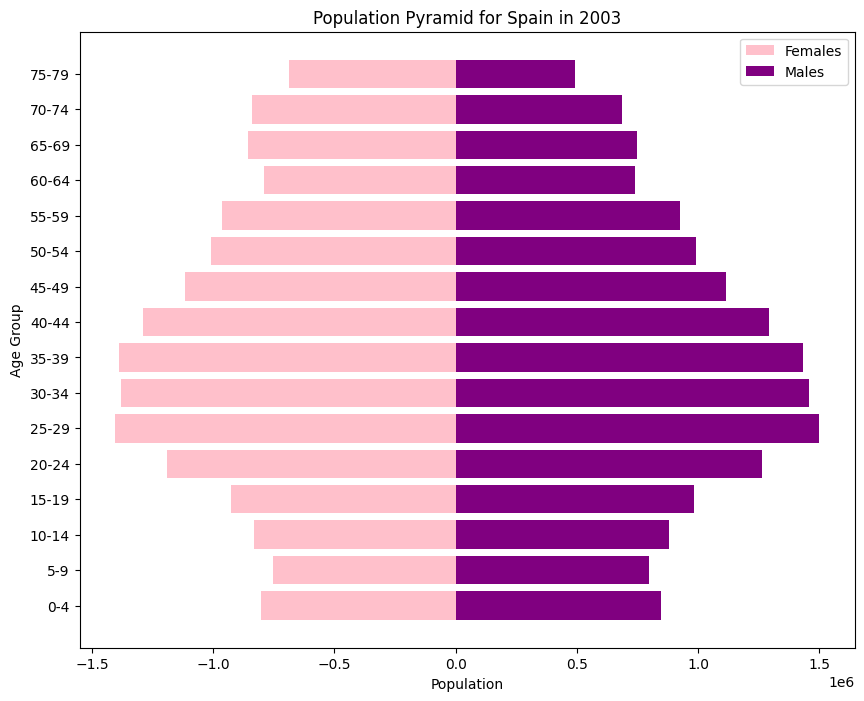

In [ ]:
# Remember that "age_groups" was previously defined
plot_population_pyramid('Spain', 2003, age_groups)

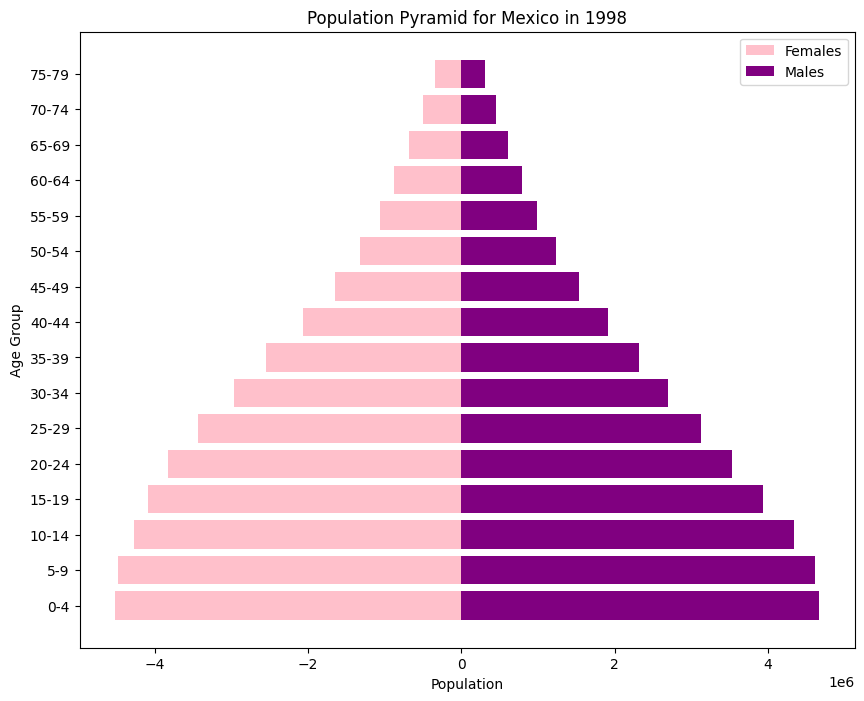

In [ ]:
plot_population_pyramid('Mexico', 1998, age_groups)

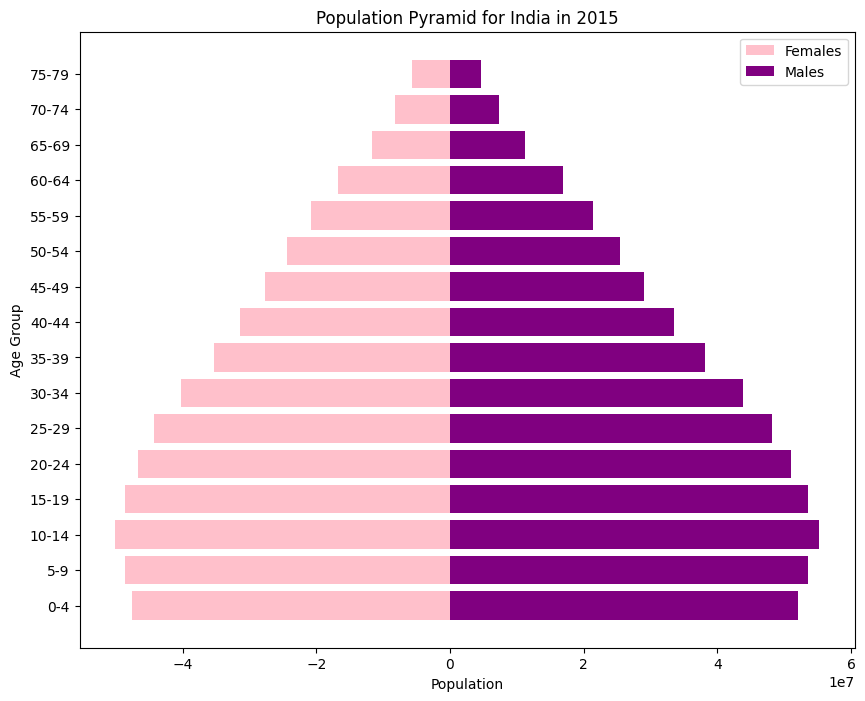

In [ ]:
plot_population_pyramid('India', 2015, age_groups)

# [A] Unit tests

Ensure functions return expected results.

In [ ]:
# This unit test assures that male population in India from the age range 0-4 is equal to 51569772 in the year 1990.
assert(population(1990, 'male',  [0, 4], 'India') == 51569772), 'Error'

In [ ]:
#This unit test assures that the total world population in the year 1990 was greater than 5,000,000,000.
assert(population(1990, 'all', [0,80], 'World') > 5000000000), 'Error'

In [ ]:
#This unit test assures that the total population of women was greater than the total population of men in Mexico in the year 2000.
assert(population(2000, 'females', [0,80], 'Mexico') > population(2000, 'males', [0,80], 'Mexico')), 'Error'

In [ ]:
#This unit test assures that the function returns birth rates for the years 2002, 2003, and 2004 for the country Spain.
assert(get_birth_rate_data("ESP", [2002, 2003, 2004]) is not None)

In [ ]:
#This unit assures that the function returns death rates for the World from the year 1997-1999.
assert(get_death_rate_data("WLD", [1997, 1998, 1999]) is not None)